# Turning Around a Polish Grocer - Internal Analysis

This notebook examines the operations of the grocer from historical sales data. Products and product categories are examined and operation changes are recommended based on the data and industry competative dynamics. 

For a complete write up, including the analysis of strategic alternatives and specific recommendations, please see the write up on my personal blog. 

**Data Files**

Sell_1.csv

    Monthly report of sell with products groups, names, amount, prices of purchase,sale and margin. 
    Data from year 2018. Products group in English, products names in Polish.


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Setting up the dataframe containing monthly sales data, including sku, cost of goods sold (COGS), contribution margin etc...

In [2]:
abr_month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
            'aug', 'sep', 'oct', 'nov', 'dec']

monthly = pd.read_csv('data/monthly_sale_by_sku.csv', delimiter=';', decimal=',', encoding='latin-1')
monthly = monthly.rename(columns={
    'Date':'date',
    'PKod':'sku',
    'Pgroup':'group',
    'Pname':'name',
    'Pquantity':'quantity',
    'pce_zn':'unit_cogs',
    'pwa_zn':'agg_cogs', #aggregate cogs for this sku
    'pce_sn':'unit_revenue',
    'pwn_sn':'agg_rev', #aggregate revenue for this sku
    'pmarza':'gross_margin',
    'pmarzajedn':'unit_contribution',
    'pkwmarza':'agg_dollar_contribution',
    'pudzmarza':'share_of_margin'
})

monthly = monthly.drop(['pwa_sn','pce_sb','pwa_sb','pudzsb'], axis=1)
monthly.group = monthly.group.str.lower()
monthly.name = monthly.name.str.lower()
monthly.date = pd.to_datetime(monthly.date, format="%d.%m.%Y")
monthly.unit_cogs = monthly.unit_cogs.str.replace(',','.').str.replace(' ','')

In [3]:
monthly.dtypes

date                       datetime64[ns]
sku                                 int64
group                              object
name                               object
quantity                          float64
unit_cogs                          object
agg_cogs                          float64
unit_revenue                      float64
gross_margin                      float64
unit_contribution                 float64
agg_dollar_contribution           float64
share_of_margin                   float64
dtype: object

Notice unit_cogs are strings, lets convert it to float

In [4]:
# Drop empty rows
idx_to_drop = monthly.unit_cogs[monthly.unit_cogs.str.len() == 0].index
monthly = monthly.drop(idx_to_drop)

# Convert to numeric
monthly.unit_cogs =  monthly.unit_cogs.astype('float')

# Add aggregate revenue column
monthly['agg_rev'] = monthly['quantity'] * monthly['unit_revenue']

In [5]:
monthly.isnull().sum()

date                       0
sku                        0
group                      0
name                       0
quantity                   0
unit_cogs                  0
agg_cogs                   0
unit_revenue               0
gross_margin               0
unit_contribution          0
agg_dollar_contribution    0
share_of_margin            0
agg_rev                    0
dtype: int64

In [6]:
monthly.sample(3)

,date,sku,group,name,quantity,unit_cogs,agg_cogs,unit_revenue,gross_margin,unit_contribution,agg_dollar_contribution,share_of_margin,agg_rev
3991,2018-03-01,886,drink_juice,hellena oranzada biala 1_25k gaz,3.0,1.35,4.05,1.99,32.16,0.64,1.92,0.01,5.97
22728,2018-12-01,17145,dairy_chesse,ser mascarpone smiet-kremowy 250g,6.0,5.85,35.10,7.91,26.04,2.06,12.36,0.07,47.46
12628,2018-07-01,4397,cigarettes,pap pal mal pstryk,5.0,10.90,54.50,11.37,4.13,0.47,2.35,0.01,56.85


Visualizing product categories and their productivity

In [7]:
# Getting the full list of categories and the number of skus within each category
category_sku_count = monthly[['sku','group']].drop_duplicates().groupby('group').count().sort_values(by='sku', ascending=False)
category_annual_contribution = monthly[['group','agg_dollar_contribution']].drop_duplicates().groupby('group').sum().sort_values(by='agg_dollar_contribution', ascending=False)
category_sku_annual_contrib = category_sku_count.join(category_annual_contribution)
# calculating aggregate dollar revenue
monthly['agg_revenue'] = monthly['quantity'] * monthly['unit_revenue']

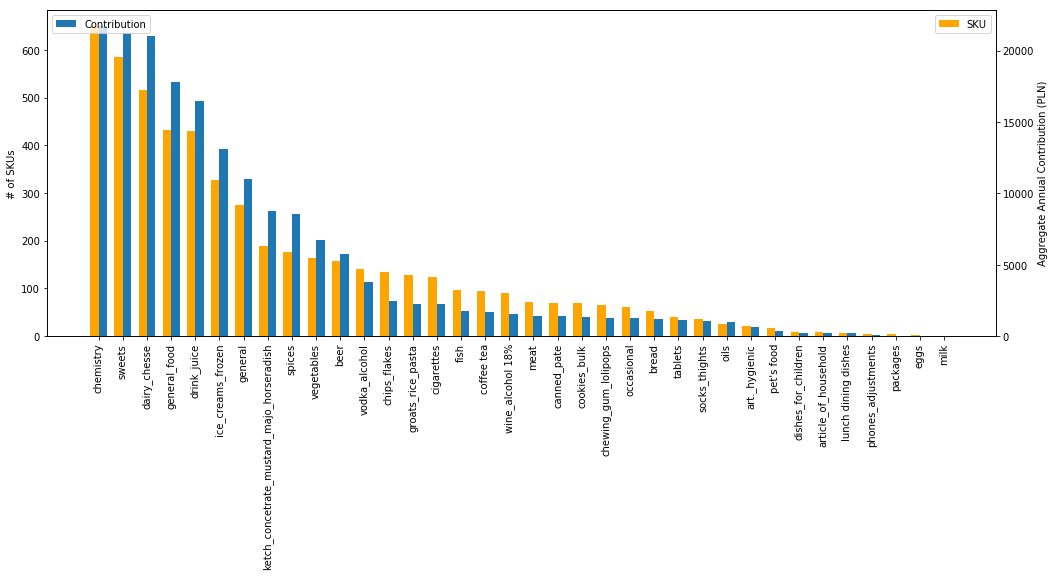

In [8]:
labels = list(category_sku_annual_contrib.index)
x = np.arange(len(labels))
width = .35

fig, ax1 = plt.subplots(figsize=(17,6))
ax1.bar(x - width/2, category_sku_count.sku, width, color=['orange'])
ax2 = ax1.twinx()
ax2.bar(x+ width/2, category_annual_contribution.agg_dollar_contribution, width)

ax1.legend(['SKU'])
ax2.legend(['Contribution'],loc=2)

ax1.set_ylabel('# of SKUs')
ax2.set_ylabel('Aggregate Annual Contribution (PLN)')

ax1.set_xticks(x)
ax1.set_xticklabels(labels, minor=False, rotation=90);

### Defining Some Helper Functions for Quality of Life Improvement

In [9]:
def get_mom_growth(df):
    """Get the month over month growth rate for input data"""
    
    growth_df = df / df.shift(1, axis=1) - 1
    return growth_df.iloc[:,1:]

def top_n_cat_by_contrib_idx(n):
    """Returns sorted n largest product categories index (pd.Int64Index) by annual aggregate revenue"""
    
    return category_contribution_by_month.sum(axis=1).sort_values(ascending=False).iloc[:n].index

def ma(df, n):
    """Returns a moving average dataframe based on given period"""
    
    return df.rolling(window=n, axis=1).mean().iloc[:,n-1:]

def cat_by_month(value, aggfunc='sum'):
    """Returns df aggregated on value (fn parameter). Returned df has product categories as rows 
    and month of year as columns"""
    
    df = monthly.pivot_table(value, index='group', columns=['date'], aggfunc=aggfunc)
    df = df.fillna(0)
    df.columns = abr_month
    return df

# These functions have some dependent dataframes
category_contribution_by_month = cat_by_month('agg_revenue') - cat_by_month('agg_cogs')

## Understanding Fresh Produce

Motivation:
- Estimate the financial value of keeping the fresh produce section

Result:
- Not strongly correlated with any major categories
- Maximum sales lift ~25% of total sales, ~ 15% is probably realistic. Will build a new attribution model when receipt level data becomes available

How:
- Due to the limitations of the dataset; specifically, the lack of receipt level data, it is difficult to accurately estimate how much sales lift fresh produce crates.
- Equally unfortunate, we don't have financial statements for the store, and therefore we can't know for sure if produce is a loss leader, but it most likely is due to industry competative dynamics and the store profile.
- The method we use will set a upper limit on Produce's sales lift, by counting anything that is positively correlated with fresh produce sales.


### Visualizing Grocery Sales Trend /w Other Categories

We will only both with the top 17 categories since they account more than ~90% of all sales

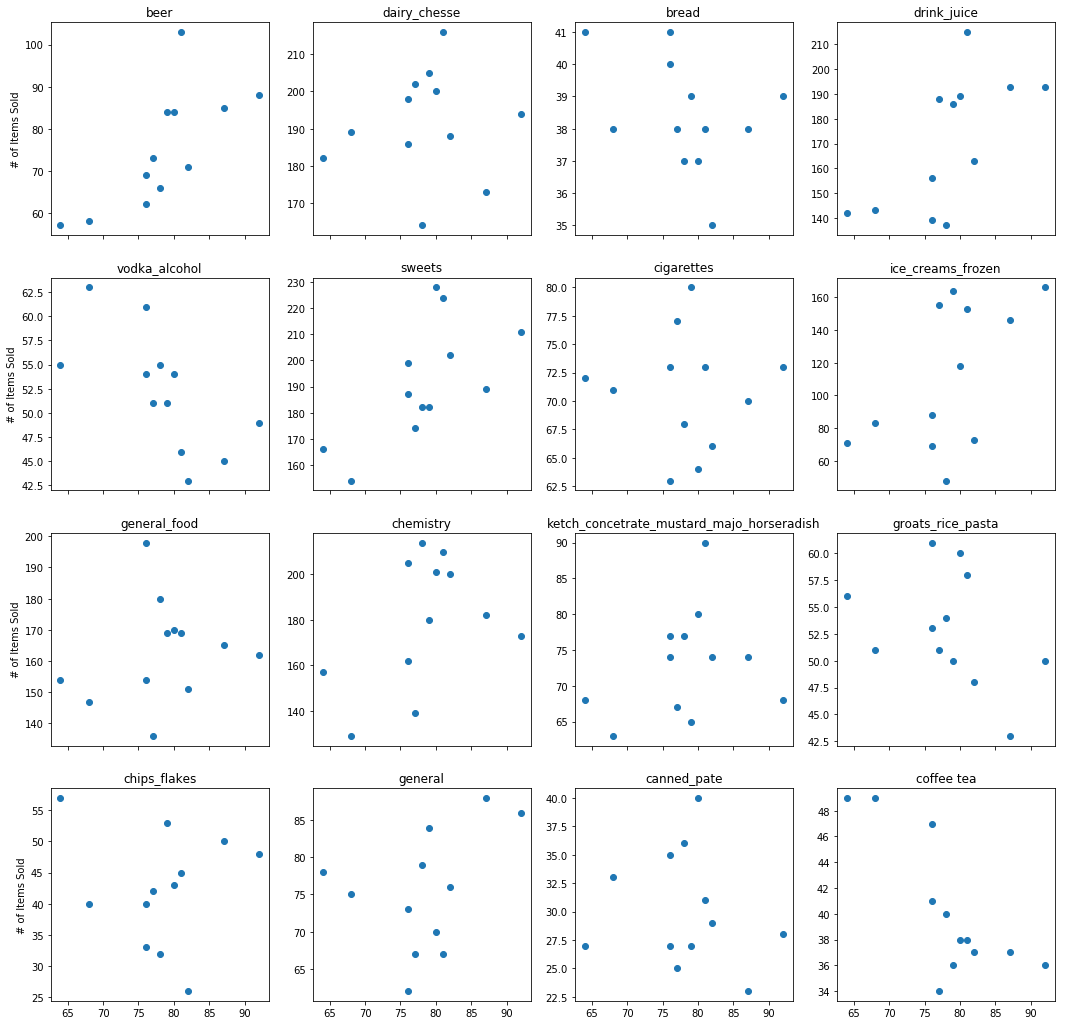

In [10]:
fig1, axs = plt.subplots(4, 4, figsize=(18,18), sharex=True)
i=0

monthly_items_sold_by_category = cat_by_month('sku','count').T
monthly_items_sold_by_category = monthly_items_sold_by_category[list(top_n_cat_by_contrib_idx(17))]

categories_ex_vegetables = list(monthly_items_sold_by_category.columns.values)
categories_ex_vegetables.remove('vegetables')

# Plotting the subplots
for row in range(9):
    for col in range(4):
        try:
            cat = categories_ex_vegetables[i]
            i += 1

            x = monthly_items_sold_by_category.vegetables
            y = monthly_items_sold_by_category[cat]
            axs[row][col].plot(x, y, 'o')
            axs[row][col].title.set_text(cat)
            if col == 0:
                axs[row][col].set_ylabel('# of Items Sold')
                
            if row == 8:
                axs[row][col].set_xlabel('# of Items Sold')            
        except:
            # Done
            break

### Estimating Grocery Sales Lift
The ceiling sales lift is calculaed by multiplying the r^2 between fresh produce and the other category by the total dollar contribution of the other category. That is, we will attribute all correlated sales as produce's sales lift. Realistically sales lift should be much lower than this ceiling figure.

In [11]:
# Making the sales correlation matrix between groceries and other categories
corr_df = pd.DataFrame(np.corrcoef(monthly_items_sold_by_category.values, rowvar=False), columns = monthly_items_sold_by_category.columns)
corr_df.index = monthly_items_sold_by_category.columns
corr_df = corr_df[['vegetables']].sort_values('vegetables', ascending=False)

corr_df.head()

group,vegetables
group,
vegetables,1.000000
beer,0.726198
sweets,0.652850
drink_juice,0.650581
ice_creams_frozen,0.574229


In [12]:
# Aggregate dollar contribution by category
contribution_by_category = monthly[['group','agg_dollar_contribution']].groupby(by='group').sum()
contribution_by_category = contribution_by_category.sort_values(by='agg_dollar_contribution', ascending=False)
contribution_by_category = contribution_by_category.join(corr_df)
contribution_by_category = contribution_by_category.rename(columns={'vegetables':'corr_w_vegetables'})

# Maximum estimated financial impact by counting everything correlated with grocery sales as sales lift
contribution_by_category['max_est_fin_impact'] = contribution_by_category['agg_dollar_contribution'] * contribution_by_category['corr_w_vegetables']

# Measuring the category's importance by calculating its share of total store's contribution pool
contribution_by_category['cat_total_contrib_share'] =  contribution_by_category['agg_dollar_contribution'] / contribution_by_category['agg_dollar_contribution'].sum()

# Contribution counted as sales lift as a percentage of total store's contribution
contribution_by_category['lift_contrib_share'] =  contribution_by_category['max_est_fin_impact'] / contribution_by_category['agg_dollar_contribution'].sum()

max_lift = contribution_by_category.loc[contribution_by_category['lift_contrib_share'] > 0, 'lift_contrib_share'].sum()

print("Max estimated lift is {0:.1f}% counting fresh produce sales, and {1:.1f}% without.".format(max_lift * 100, (max_lift - .1) * 100))

Max estimated lift is 34.9% counting fresh produce sales, and 24.9% without.


In [13]:
# Looking at the dataframe containing sales lift data
contribution_by_category.sort_values('max_est_fin_impact', ascending=False).head()

,agg_dollar_contribution,corr_w_vegetables,max_est_fin_impact,cat_total_contrib_share,lift_contrib_share
group,,,,,
vegetables,22401.82,1.000000,22401.820000,0.103134,0.103134
beer,22460.91,0.726198,16311.074200,0.103406,0.075093
drink_juice,17633.21,0.650581,11471.839433,0.081180,0.052814
sweets,14134.36,0.652850,9227.616352,0.065072,0.042482
ice_creams_frozen,11277.78,0.574229,6476.029963,0.051921,0.029814


## Sales Trends, Best Performing Categories & SKUs

#### SKUs sold Vs. Revenue

Results:
- Total revenue highly correlated with number of items sold, with the exception of December. Consumers were trading up during December and not other time of year. This could be due to the Christmas Holidays.

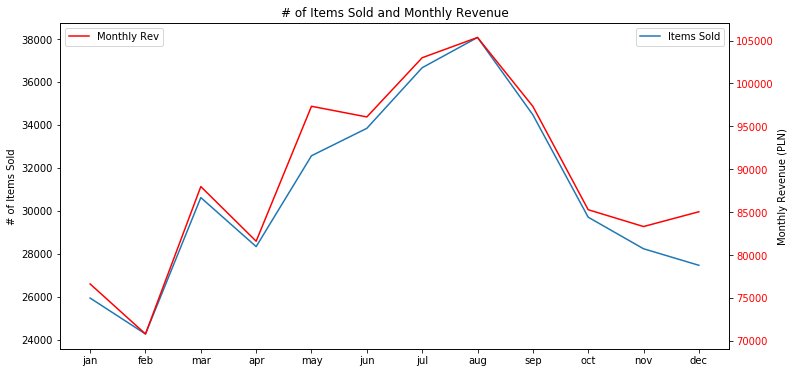

In [14]:
# Grabbing data for skus sold and revenue per month
monthly_aggregate_skus_sold = cat_by_month('quantity').sum(axis=0)
monthly_aggregate_revenue = cat_by_month('agg_revenue').sum(axis=0)
monthly_aggregate_revenue.index = monthly_aggregate_skus_sold.index

# plotting side by side
rev_sku_fig = plt.figure(figsize=(12,6))
ax1 = rev_sku_fig.add_subplot(111)
ax1.plot(monthly_aggregate_skus_sold)
ax1.set_ylabel('# of Items Sold')

ax2 = ax1.twinx()
ax2.plot(monthly_aggregate_revenue, 'r-')
ax2.set_ylabel('Monthly Revenue (PLN)')

ax1.set_title("# of Items Sold and Monthly Revenue")

ax1.legend(['Items Sold'])
ax2.legend(['Monthly Rev'],loc=2)

for tl in ax2.get_yticklabels():
    tl.set_color('r')

## Finding Under-Performing Categories

### Q:How many SKUs can we drop and still keep 90% of our revenue? How much cash can we raise by selling stock?

Result:
- We can drop 60% of our total SKUs and still keep 90% of our total revenue
- Generate $14,000 PLN via stock liqudiation
- Cash and freed up space can be used to upgrade/renovate store


- **Biggest non-performing categories are**
    - Household chemicals (chemistry)
    - General
    - Wine
    - Sweets
    - Bulk cookies
  
  
- ** Categories that has expansion potential **
    - Bread
    - Vodka / Spirits
    - Beer
    - Cigarettes

Implication:
- Lots of excess shelf space in the store, which gives us the opportunity to dramatically adjust the store layout, product display, and to introduce new product categories etc...

Assumptions:
- 35% discount on retail when liquidating stock
- 5 items in stock per SKU

#### Making a Product Table

In [15]:
# Products, a df conaining SKU, product group and product name
products = monthly[['group','sku','name']].drop_duplicates().set_index('sku')
products.head()

,group,name
sku,,
5307,chemistry,patyczki bella 200
5986,chemistry,ace 1 l
399,dairy_chesse,almette czosnek niedzwiedzi 150gr
2246,dairy_chesse,almette jogurtowy 150g hochland
2247,dairy_chesse,almette ogorek/ziola 150g


#### Cumulative Revenue by nth Top Performing SKUs

In [16]:
monthly_sku_revenue = monthly[['date','sku','agg_revenue']].pivot_table('agg_revenue', index='sku', columns='date')
monthly_sku_revenue = monthly_sku_revenue.fillna(0)
monthly_sku_revenue.columns = abr_month
monthly_sku_revenue['annual_total'] = monthly_sku_revenue.sum(axis=1)
monthly_sku_revenue = monthly_sku_revenue.sort_values('annual_total', ascending=False)

# Calculating each SKU's share of overall revenue
product_performance = monthly_sku_revenue.join(products)
product_performance['rev_share'] = product_performance['annual_total'] / product_performance['annual_total'].sum()

In [17]:
# Sort by most performent SKU based on annual contribution and calculating cumulative revenue
product_performance['cumulative_rev'] = product_performance['rev_share']

cumulative_revenue_share = 0.0
for idx, row in product_performance.iterrows():
    product_performance.loc[idx,'cumulative_rev'] = cumulative_revenue_share + row['rev_share']
    cumulative_revenue_share += row['rev_share']
    
# Making a pricing table to hold product pricing information
pricing = monthly[['sku','unit_cogs','unit_revenue']]
# In case there are multiple prices for a single SKU, we'll take the mean
pricing = pricing.groupby('sku').mean()

# Joining dfs together
product_performance = product_performance.join(pricing)
print(f'there are {product_performance.shape[0]} SKUs sold by the store within the last yr, \
but many also has not made a sale in months')

there are 5277 SKUs sold by the store within the last yr, but many also has not made a sale in months


In [18]:
product_performance.head()

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,annual_total,group,name,rev_share,cumulative_rev,unit_cogs,unit_revenue
sku,,,,,,,,,,,,,,,,,,,
304,1955.20,2088.1700,3087.980,3372.84,3898.96,3760.41,3867.99,3929.4400,3127.91,1805.27,2127.580,1681.690,34703.4400,beer,piwo zubr 0_5l butelka,0.032440,0.032440,1.3800,1.637500
374,2625.48,2384.2800,2737.260,2081.82,2872.80,2537.04,3177.20,3458.9100,3339.84,3167.80,2988.120,2974.790,34345.3400,dairy_chesse,gos.maslo 250g gostyn,0.032106,0.064546,6.3750,6.645000
8934,1524.39,1559.7600,1737.310,1684.38,1742.00,1749.37,1810.34,1832.4500,1933.33,1866.59,1886.470,1915.580,21241.9700,bread,bulka mala/kajzerka__,0.019857,0.084403,0.5325,0.678333
14233,2079.77,1221.0000,1994.300,1664.63,1461.13,1359.38,1615.79,1575.0900,1815.22,1302.40,879.120,647.130,17614.9600,phones_adjustments,pompka simplus 5 zl,0.016466,0.100869,3.8275,4.070000
3,1179.57,1180.2462,1474.095,1333.20,1380.16,1418.04,1532.16,1476.2305,1602.12,1525.68,1344.335,1310.531,16756.3677,bread,c chleb krojony 0_6 kg,0.015664,0.116533,2.6000,3.050833


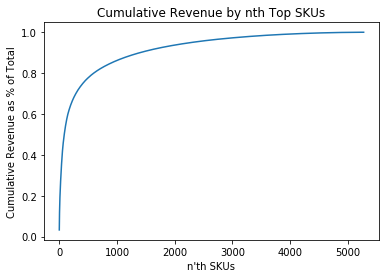

In [19]:
# Plotting Cumulative Revenue
cumulative_revenue = pd.DataFrame(product_performance['cumulative_rev'].values)

plt.plot(cumulative_revenue.values)
plt.title('Cumulative Revenue by nth Top SKUs')
plt.xlabel("n'th SKUs")
plt.ylabel("Cumulative Revenue as % of Total");

#### Dropping Underperforming SKUs & Assess Financial Impact

Results:
#### 90% of Store's Revenue is made by ~ 40% of SKUs, 50% by ~10% of SKUs
- There are about 4k active SKUs
- This means we can strip many underperforming products and do something else with the space we have. We will also be able to raise some capital through the sale of inventory

In [20]:
def get_sku_status(df, n_months, active=True):
    """Returns the index of active or inactive SKUs. A inactive SKU is one that has not made a
    in the last n_months. We will assume it has been already taken off the shelf.
    
    Args:
        df: df
            product dataframe containing product sku, culative revenue, unit cogs, and unit revenue
        
        n_months: int
            A SKU that has not made a sale in n_months will be marked as inactive
            
        active: bool
            Returns active SKU indexes when set to True, returns inactive SKU indexes when False
            
    
    Returns:
        idx: pd.Int64Index
            Pandas Row Index of active or inactive SKUs
    """
    start_month = abr_month[-n_months]
    df['rev_last_n_months'] = df.loc[:, start_month:"dec"].sum(axis=1)
    
    if active:
        return df[df['rev_last_n_months'] > 0].index
    
    else:
        return df[df['rev_last_n_months'] <= 0].index
    


def working_capital_used_by_underperfoming_products(df, rev_to_keep, liquidation_discount, inventory_per_sku):
    """Calculate the amount of working capital used by non-performent SKUs, and the amount of capital
    that can be released from liduidating these non-performent SKUs. You can specify the amount of
    revenues you wish to retain. (IE, find the long tail SKUs that constitues the latst 10% of revenue)
    
    Args:
        df: df
            product dataframe containing product sku, culative revenue, unit cogs, and unit revenue
            
        rev_to_keep: float 
            Amount of revenue to *keep*, ranges from 0 to 1, 1 being keeping all revenue and not 
            dropping any skus. Similarily, 0 being keeping no revenue and dropping all SKUs
        
        liquidation_discount: float
            A discount (0 to 1) applied to retail price to clear inventory. It is used to calcualte
            amount of capital that can be freed up via inventory liquidation
    
    Returns:
        working_cap_invested: float
            Amount of working capital invested in non-performent SKUs
        
        working_cap_freed: float
            Amount of working capital to be freed by liquidating stock at liquidation discount
            
        num_skus_dropped: int
            Number of SKUs dropped
            
        idx_skus_dropped: df.Int64Index
            dataframe index of SKUs that will be dropped
            
    """    
    # Get a list of active SKUs (SKU that made sales in last 3 months)
    active_skus_idx = get_sku_status(df, 3, active=True)
    df = df.loc[active_skus_idx,:].copy()
    
    active_skus = df.shape[0]
    
    # Calculating working capital and liquidation value
    df['working_cap'] = df['unit_cogs'] * inventory_per_sku
    df['liquidation_cf'] = df['unit_revenue'] * liquidation_discount * inventory_per_sku
    
    # return totals for given revene share to keep
    df_to_liquidate = df[df['cumulative_rev'] >= rev_to_keep]
    total_wc = df_to_liquidate['working_cap'].sum()
    total_liquidation_cf = df_to_liquidate['liquidation_cf'].sum()
    
    num_skus_dropped = df_to_liquidate.shape[0]
    num_skus_dropped_frac = num_skus_dropped / active_skus * 100
    
    idx_skus_dropped = df_to_liquidate.index
    
    print("Total working capital invested in SKUs to be liquidated is ${0:.0f} PLN".format(total_wc))
    print("Total amount of cash generated from liquidating underperforming SKUs is ${0:.0f} PLN".format(total_liquidation_cf))
    print("Total number of active SKUs to be dropped from store is {0:.0f}, representing {1:.0f}% of your SKUs".format(num_skus_dropped, num_skus_dropped_frac))
    
    return total_wc, total_liquidation_cf, num_skus_dropped, idx_skus_dropped

In [21]:
_, _, _, idx_skus_dropped = working_capital_used_by_underperfoming_products(product_performance, .9, 0.35, 5);

Total working capital invested in SKUs to be liquidated is $29350 PLN
Total amount of cash generated from liquidating underperforming SKUs is $14014 PLN
Total number of active SKUs to be dropped from store is 1736, representing 60% of your SKUs


In [22]:
def explore_dropped_sku_categories(product_performance, idx_skus_dropped, n_months):
    """
    Calculates number of SKUs to be dropped in each product category and compare it to the total
    number of SKUs in that produce category
    
    Args:
        product_performance: df
            product dataframe containing product sku, culative revenue, unit cogs, and unit revenue
            
        idx_skus_dropped: pd.Int64Index
            index conaining skus to be dropped
            
        n_months: int
            Threshold in months used in marking a item as inactive. Every SKU that has made 
            a sale in the last n_months are considered active, and as such, is assumed to be
            currently in inventory. Active SKUs are counted towards category SKU total. Inactive
            SKUs are not.
            
    """
    skus_dropped = product_performance.loc[idx_skus_dropped,:].groupby('group').count()
    skus_dropped = pd.DataFrame(skus_dropped.name.sort_values(ascending=False))
    skus_dropped.columns = ['skus_dropped']
    
    active_skus_idx = get_sku_status(product_performance, 3, active=True)
    active_skus = product_performance.loc[active_skus_idx,:]

    # Count the categories
    active_skus_per_category = active_skus.groupby('group').count()
    active_skus_per_category = pd.DataFrame(active_skus_per_category.name)
    active_skus_per_category.columns = ['cat_total']

    # Join the dfs and normalize
    df = skus_dropped.join(active_skus_per_category)
    df['frac_dropped'] = df.skus_dropped / df.cat_total
    
    return df

In [23]:
explore_dropped_sku_categories(product_performance, idx_skus_dropped, 3).sort_values('frac_dropped', ascending=False)

,skus_dropped,cat_total,frac_dropped
group,,,
article_of_household,3,3,1.000000
socks_thights,21,24,0.875000
general,124,142,0.873239
chemistry,312,362,0.861878
art._hygienic,15,18,0.833333
spices,75,92,0.815217
wine_alcohol 18%,40,51,0.784314
occasional,22,29,0.758621
fish,47,63,0.746032


### Understanding Sales Trend

Goal:
- Understand the reasons behind the current sales trend
- Figure out which categories are well positioned for growth, and which look the least favorable

Implication
- In the winter months you can exploit the fact that people don't want to hop into the car and go to the large supermarkets, and increase price on staple categories such as fresh produce, cheese, and bread.
- Generally speaking you should increase the margins on produce, the data suggests it has low price elasticity.
- Consider expanding drink and beer selection during the summer months, and perhaps run more promotions during winter months to counter cyclicality

How:
- By examing the changes in the following statistics for each product category. We'll use median for all statistics because this dataset has many outliers
    - Median selling price (are customers switching to lower end products?)
    - median contribution margin (absorbing the cost increase? Change in pricing power?)
    - Total volume (Are people trading up/down or not buying at all?)
    
    
Results:
#### First look at store level performance

- There is significant margin expansion in the second half of the year, thanks to
    - Fresh produce
    - Cheese
    
    
- Margin has been weighted down by
    - Bread

#### Category Specific Trends
**Revenue Trends**
- **Fresh produce has relative low price elasticity** so the data suggest you do have some pricing power here, likely due to the store's convinence factor. You can explore upping your margins while closely monitoring sales volume.
- All categories are cyclical
- Drop in revenue towards the second half of the year was largely due to slowing sales of drink_juice and beer.
- This dataset exhibits strong cyclicality trends in your significant categories. Beer ad drink_juice's seasonality trends are dragging down store's revenue generation in colder months.

**Product Rotation**
- It is difficult to advise on product rotation when all the categories exhibit the same seasonality trends, that is, universaly lower sales during winter months. As such, it is critical that the new market positioning incorporates products that sells well during winter months. Alternatively, you can have a strong and differentiated positioning selling a consumer staple that shows strong demand throughout the year.

*Most Seasonal Product Category*
- Drinks and Juice
- Beer
- Sweets
- Cigarettes
- Diary and Cheese
- Fresh produce
- Vodka & Spirit
- Bread

*Least Seasonal*

In [24]:
store_by_month = monthly[['date','quantity','agg_rev', 'agg_dollar_contribution']].groupby('date').sum()
store_by_month['gross_margin'] = store_by_month['agg_dollar_contribution'] / store_by_month['agg_rev']
store_by_month.head()

,quantity,agg_rev,agg_dollar_contribution,gross_margin
date,,,,
2018-01-01,25932.62,76619.8083,13573.27,0.177151
2018-02-01,24259.68,70786.7168,13631.43,0.192570
2018-03-01,30612.37,87977.7103,17478.31,0.198667
2018-04-01,28329.33,81604.0676,16242.70,0.199043
2018-05-01,32561.19,97341.7113,20251.11,0.208041


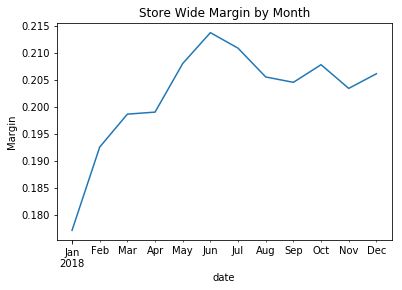

In [25]:
# Loser look at margins
store_by_month['gross_margin'].plot()
plt.ylabel('Margin')
plt.title("Store Wide Margin by Month");

#### Margin Analysis by Category

In [26]:
# Contribution magin for each category, broek down by months
# Contribution margin = 1 - aggregate_cogs / aggregate_revenue
category_contribution_margin_by_month = 1 - cat_by_month('agg_cogs') / cat_by_month('agg_revenue')

# Store baseline performance
store_baseline_margin = 1 - cat_by_month('agg_cogs').sum() / cat_by_month('agg_revenue').sum()

category_contribution_margin_by_month.head()

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
group,,,,,,,,,,,,
art._hygienic,0.341443,0.343337,0.341121,0.327369,0.321437,0.303039,0.354008,0.346140,0.330587,0.329996,0.289881,0.294395
article_of_household,0.327703,0.335938,0.320499,0.365095,0.338048,0.322581,0.351254,0.301887,0.306569,NaN,NaN,0.317125
beer,0.228322,0.225629,0.216091,0.228100,0.215018,0.208671,0.208062,0.238731,0.224334,0.224656,0.212278,0.220428
bread,0.146066,0.185999,0.210260,0.208756,0.223266,0.218959,0.180553,0.182606,0.200194,0.178734,0.168410,0.178313
canned_pate,0.265463,0.259811,0.252850,0.279858,0.289549,0.277049,0.279122,0.266056,0.268516,0.265583,0.269575,0.244895


In [27]:
# We want to subtract category growth by baseline store level performance to see which category is 
# Over performing, and which category is underperforming relative to baseline.

# Pandas doesn't support broadcasting so we'll make the df ourselves
base_row = pd.DataFrame(store_baseline_margin).T
to_append = []
for idx in list(category_contribution_margin_by_month.index):
    to_append.append(base_row.rename({0:idx}))

broadcasted_baseline_margin = pd.concat(to_append)

In [28]:
# Month over month margin change
category_margin_performance = get_mom_growth(category_contribution_margin_by_month)
category_margin_performance = category_margin_performance.sort_values('jun', ascending=False).loc[top_n_cat_by_contrib_idx(8),:]

# Month over month margin change over baseline (store wide m/m margin change)
category_margin_performance_over_baseline = get_mom_growth(category_contribution_margin_by_month) - get_mom_growth(broadcasted_baseline_margin)
category_margin_performance_over_baseline = category_margin_performance_over_baseline.sort_values('jun', ascending=False).loc[top_n_cat_by_contrib_idx(7),:]

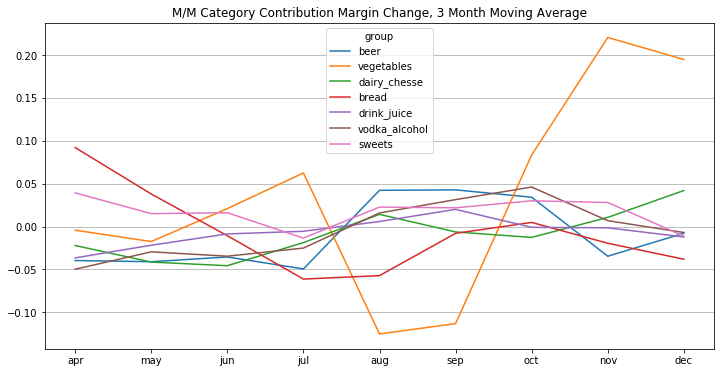

In [29]:
# Using 3 month moving average to smooth out the volatility a bit more and make the trend more appearant

fig, ax = plt.subplots(1, figsize=(12,6))
ma(category_margin_performance_over_baseline, 3).T.plot(ax=ax)
ax.set_title("M/M Category Contribution Margin Change, 3 Month Moving Average")
ax.grid(axis='y')
ax.set_xticklabels(category_margin_performance.T.index[1:]);

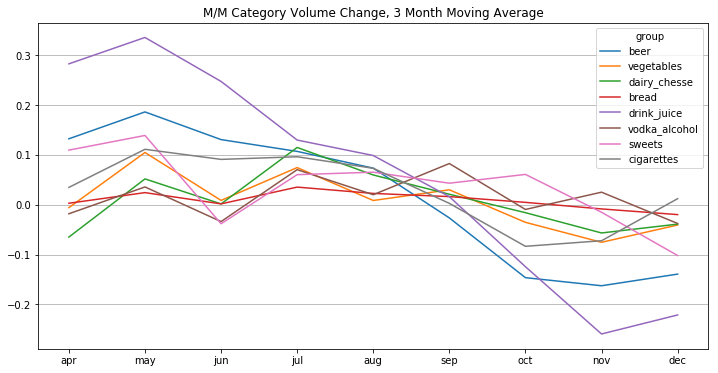

In [30]:
# Seems like the positive margin expansion has been casued by the margin expansion of fresh produce
# Explore more by looking at volume change
category_quantity_performance = get_mom_growth(cat_by_month('quantity')).loc[top_n_cat_by_contrib_idx(8),:]

fig, ax = plt.subplots(1, figsize=(12,6))
ma(category_quantity_performance, 3).T.plot(ax=ax)
ax.set_title("M/M Category Volume Change, 3 Month Moving Average")
ax.grid(axis='y')
ax.set_xticklabels(category_quantity_performance.T.index[1:]);

# SKU Analysis

Goal:
- Find the best performing and upcoming product SKUs and use them to drive cash flow generation and foot traffic to the store.

### Anchor Products / Highest Performing SKUs
Anchor products are high performence products that generates the bulk of store's free cash flow. Make sure these products are displayed in the middle of the isle, where people are most likely to notice and buy them. Also, spread them around the store to drive foot traffic evenly throughout the store, with the goal of getting the customer to take a whole tour of the store before leaving. 

Results:
- See analysis below

### High Growth Products
Results:
- See analysis below

#### Product Rotation: Getting the best performing SKU for each quarter of the year
You can then use this to advise on product rotation throughout the year

In [31]:
def get_best_product_for_quarter(q, top_n=200):
    """Get a list of best performing products for a given quarter
    
    Args:
        q: int
            Quarter of the year, 1 to 4
            1: Start of Jan - end of Mar
            2: Start of Apr - end of Jun
            3: Start of Jul - end of Sept
            4: Start of Oct - end of Dec
        
        top_n: int
            Get up to top nth SKU
    
    Returns:
        df: DataFrame
            df containg best performing SKUs
    """
    df = product_performance.copy()
    df['q1_contrib'] = df.loc[:,'jan':'mar'].sum(axis=1)
    df['q2_contrib'] = df.loc[:,'apr':'jun'].sum(axis=1)
    df['q3_contrib'] = df.loc[:,'jul':'sep'].sum(axis=1)
    df['q4_contrib'] = df.loc[:,'oct':'dec'].sum(axis=1)
    
    quarters = {1:'q1_contrib', 2:'q2_contrib', 3:'q3_contrib', 4:'q4_contrib'}
    
    quarter = quarters[q]
    
    return df.sort_values(quarter, ascending=False).iloc[:top_n,:]

In [32]:
get_best_product_for_quarter(1).head()

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,...,name,rev_share,cumulative_rev,unit_cogs,unit_revenue,rev_last_n_months,q1_contrib,q2_contrib,q3_contrib,q4_contrib
sku,,,,,,,,,,,,,,,,,,,,,
374,2625.48,2384.2800,2737.260,2081.82,2872.80,2537.04,3177.20,3458.9100,3339.84,3167.80,...,gos.maslo 250g gostyn,0.032106,0.064546,6.3750,6.645000,9130.710,7747.0200,7491.66,9975.9500,9130.710
304,1955.20,2088.1700,3087.980,3372.84,3898.96,3760.41,3867.99,3929.4400,3127.91,1805.27,...,piwo zubr 0_5l butelka,0.032440,0.032440,1.3800,1.637500,5614.540,7131.3500,11032.21,10925.3400,5614.540
14233,2079.77,1221.0000,1994.300,1664.63,1461.13,1359.38,1615.79,1575.0900,1815.22,1302.40,...,pompka simplus 5 zl,0.016466,0.100869,3.8275,4.070000,2828.650,5295.0700,4485.14,5006.1000,2828.650
8934,1524.39,1559.7600,1737.310,1684.38,1742.00,1749.37,1810.34,1832.4500,1933.33,1866.59,...,bulka mala/kajzerka__,0.019857,0.084403,0.5325,0.678333,5668.640,4821.4600,5175.75,5576.1200,5668.640
3,1179.57,1180.2462,1474.095,1333.20,1380.16,1418.04,1532.16,1476.2305,1602.12,1525.68,...,c chleb krojony 0_6 kg,0.015664,0.116533,2.6000,3.050833,4180.546,3833.9112,4131.40,4610.5105,4180.546


In [33]:
# What categories do top SKUs in Q1 belong to?
# If you do this for all 4 quarters you will see these rankings stays relatively constant, 
# meaning all categories exhibit similar seasonality trends
get_best_product_for_quarter(1).group.value_counts().head(7)

cigarettes       41
vegetables       25
bread            24
dairy_chesse     24
vodka_alcohol    23
drink_juice      12
beer             11
Name: group, dtype: int64

In [34]:
# Getting a list of products that have significant sales. This will make sure we have meaningful month over month
# growth metrhics. We'll use 1500 PLN annual sales as the bar

def get_highest_growth_skus(top_n, min_annual_pln, month):
    """Returns a dataframe with highest growth skus
    
    Args:
        top_n: int
            Get top n high growth skus
            
        min_annual_pln: int
            Minimum annual sales in PLN the sku needs to make in order for it to be considered as a potential
            high growth candidate
            
        month: str
            Abbrevated month to rank the high growth skus
            
    Returns:
        df: DataFrame
            df containing high growth skus sorted by the month of choice, values in df are 2 month 
            moving average of dollar contribution growth
    
    """
    significant_skus_idx = product_performance[product_performance.annual_total > min_annual_pln].index

    # High Growth Products
    high_growth_skus = ma(get_mom_growth(product_performance.copy().loc[:,'jan':'dec']), 2)

    high_growth_skus = high_growth_skus.loc[significant_skus_idx,:].sort_values(month, ascending=False)
    
    high_growth_skus = high_growth_skus.join(product_performance[['group','name']])
    
    return high_growth_skus

In [35]:
# Getting the highest growth SKUs for jun, next year this time you can promote these a bit more, put them on
# better shelf locations etc...

get_highest_growth_skus(200, 1500, 'jun').head()

,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,group,name
sku,,,,,,,,,,,,
15612,NaN,NaN,NaN,7.544180,-0.327270,NaN,NaN,NaN,NaN,NaN,vegetables,kt truskawki kg.
9380,NaN,NaN,5.301813,2.516216,0.023309,-0.174514,-0.013607,0.022748,-0.079341,0.142659,vegetables,kt ziemniak wczesny kg
277,-0.253323,-0.211010,1.132978,1.324529,-0.040267,0.044381,0.415034,0.112238,-0.155521,-0.230972,vegetables,kt kalafior
12405,-0.486842,-0.500000,0.550000,0.953846,0.477376,0.091387,0.567857,0.517949,-0.399698,0.305430,vodka_alcohol,wodka krupnik premium 0_2l
15403,-0.500404,0.266667,0.666667,0.928571,0.578571,0.291256,0.579474,0.168987,0.178138,-0.111455,cigarettes,pap rothmans blu link
